In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.ardl as ardl
import math
import pmdarima as pm

import lead_lag as ll

In [71]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.rename(columns=lambda c: str(c), inplace=True)
# df["time"] = pd.to_datetime([i for i in range(1000)], unit='D', origin=pd.Timestamp('2020-01-01'))
# df.set_index("time", inplace=True)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,12.16671,66.190820,46.245800,45.805040,53.434400,9.80468,17.790600,50.959960,68.03811,54.033990,...,30.350180,71.991100,11.406310,57.9546,33.568220,50.340710,67.87408,34.611200,40.585290,54.836260
std,1.99461,4.171327,1.242464,2.816865,2.763579,2.07627,0.661056,5.354948,0.96049,4.836732,...,1.619163,10.570417,1.337563,5.2817,3.634882,2.651905,11.37598,0.808334,4.040864,1.667924
min,8.52000,59.610000,43.810000,41.690000,47.190000,6.38000,16.220000,44.010000,65.64000,45.260000,...,26.720000,50.620000,9.240000,44.3300,26.660000,43.980000,49.20000,32.800000,31.640000,51.500000
25%,10.25000,63.067500,45.530000,43.367500,51.697500,7.80500,17.290000,46.690000,67.55750,49.537500,...,28.840000,64.627500,10.387500,56.9950,29.887500,48.417500,55.42750,34.047500,37.377500,53.465000
50%,12.94000,64.905000,46.445000,45.550000,53.480000,9.99000,17.970000,48.610000,68.19000,54.515000,...,30.715000,74.905000,11.140000,59.6750,33.945000,50.715000,65.76000,34.615000,40.990000,54.640000
75%,13.59000,68.292500,46.972500,47.830000,55.875000,11.85000,18.340000,55.660000,68.73000,57.995000,...,31.590000,80.970000,12.210000,61.4225,36.822500,52.372500,79.56500,35.162500,43.822500,56.110000
max,15.56000,75.150000,48.610000,51.010000,59.120000,13.00000,18.980000,63.330000,69.99000,63.520000,...,33.260000,88.000000,14.500000,66.0900,39.130000,54.150000,86.42000,36.480000,50.020000,59.310000


In [4]:
# Check if stationary
# Non-stationary
def test_stationary(series):
    print("Results of Dickey-Fuller Test:")
    dftest = stattools.adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    print("Results of KPSS Test:")
    kpsstest = stattools.kpss(series, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

test_stationary(df["8"])

Results of Dickey-Fuller Test:
Test Statistic                  -2.227240
p-value                          0.196508
#Lags Used                       1.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64
Results of KPSS Test:
Test Statistic            2.403028
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_16852\2492717299.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")


In [72]:
from datetime import datetime, timedelta

train = df.iloc[:750, :]
# train.index = index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(train.shape[0])]
mvgTrain = train[:].rolling(5).mean()

test = df.iloc[750:, :]
# test.index = index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(test.shape[0])]
mvgTest = test[:].rolling(5).mean()

0.9881772796362251
0.6048711914568213


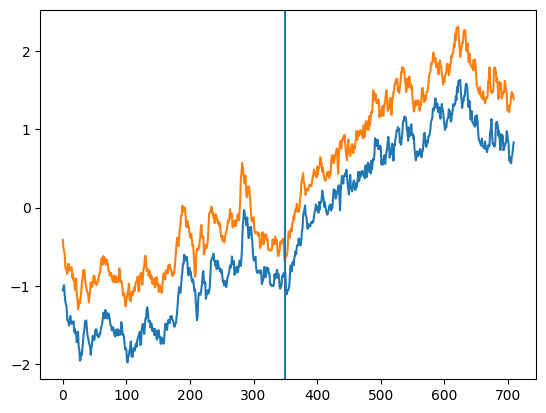

In [6]:
# Check for lead lags
# (18, 3): Not accurate enough
share1 = "36"
share2 = "7"
lag = 290

standard1 = (df[share1] - df[share1].mean())/df[share1].std()
standard2 = (df[share2] - df[share2].mean())/df[share2].std()
shifted1 = pd.Series(np.array(standard1)[:-lag])
shifted2 = pd.Series(np.array(standard2)[lag:])

print(shifted1.corr(shifted2))
print(df[share1].corr(df[share2]))

sns.lineplot(shifted1)
sns.lineplot(shifted2)
plt.axvline(350)


In [10]:
# results = {}
# for i in range(50):
#     for j in range(i+1, 50):
#         t1, t2 = str(i), str(j)
#         lag = ll.lag(mvgTrain[t1], mvgTrain[t2], max_lag=300)
#         lag = int(lag)
#         # test for cointegration
#         if lag > 0:
#             # t1 leads t2, shift t1 forward

#             pass
#         elif lag < 0:
#             # other way
#             t1, t2 = t2, t1
#             lag = -lag
#         else:
#             continue

#         shiftt1 = train[t1][lag:]
#         shiftt2 = train[t2][:-lag]
#         res = sm.tsa.stattools.coint(shiftt1, shiftt2)
#         corr = shiftt1.corr(shiftt2)
#         results[t1,t2] = (res[1], corr, lag)


In [89]:
# Predict function for lead lag
memo = {}
def predict_next(df, ticker, indices, lags):
    if ticker not in memo:
        result = ardl.ARDL(
            df[ticker].pct_change().dropna().values[:],
            0,
            df[indices].pct_change().dropna().values[:],
            lags,
            causal=True
        ).fit()

        memo[ticker] = result.params

    param = memo[ticker]

    pct = df.pct_change().dropna()
    predict_val = np.sum(pct[indices].iloc[lags * -1, :].values.T.flatten() * param[1:]) + param[0]
    return [predict_val]

In [ ]:
# # Predict function for lead lag with moving average
# def predict_next_mvg(df, ticker, indices, lags, shift, currentPoint):
#     matchedSeries = df[indices].rolling(5).mean().dropna().values
#     if len(indices) > 1:
#         matchedSeries = matchedSeries[currentPoint-shift-199:currentPoint-shift+1, :]
#     else:
#         matchedSeries = matchedSeries[currentPoint-shift-199:currentPoint-shift+1]
    
#     predictSeries = df[ticker].rolling(5).mean().dropna().values[currentPoint-199:currentPoint+1]
#     # print(matchedSeries.shape)
#     # print(len(predictSeries))

#     result = ardl.ARDL(
#         predictSeries,
#         0,
#         matchedSeries,
#         lags,
#         causal=True
#     ).fit()

#     predict_val = result.forecast()
#     # print(predict_mu)
#     return predict_val

43.3925 2.891725211073188
-0.007520342657379674 0.17485301719433324
0.03411290322580646 0.40592377198033563
MSE error 0.12692058031773001


(0     -0.158113
 1     -0.132431
 2      0.222751
 3      0.112966
 4     -0.183230
          ...   
 243   -0.117128
 244   -0.237760
 245   -0.022937
 246   -0.027369
 247    0.126921
 Length: 248, dtype: float64,
 0     -0.06
 1      0.22
 2      0.37
 3      0.32
 4      0.19
        ... 
 243   -0.24
 244    0.20
 245   -0.11
 246   -0.33
 247   -0.41
 Length: 248, dtype: float64)

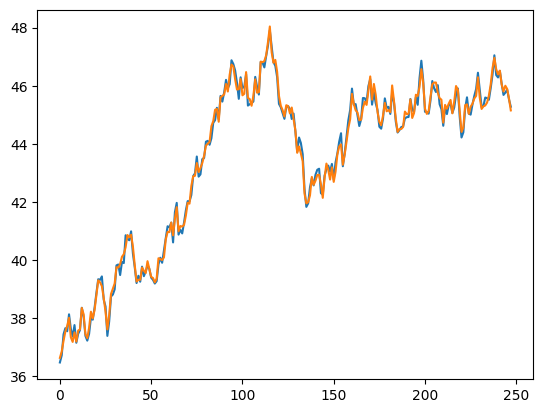

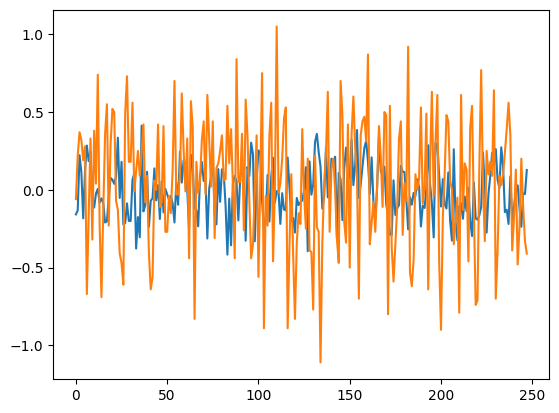

In [100]:
def test_error(sharePredict, indices, lags, printing=False):
    predictValues = []
    errors = []
    actuals = []

    actual_changes = []
    predict_changes = []

    for i in range(751, 999):
        actual_values = df[sharePredict].values

        # For pct_change
        predict_change = predict_next(df.iloc[:(i+1), :], sharePredict, indices, lags)[-1]
        predict = actual_values[i] * (1 + predict_change)

        # predict = predict_next(df, sharePredict, indices, lags, shift, i)[-1]
        

        actual = actual_values[i+1]
        error = predict - actual

        errors.append(error)
        actuals.append(actual)
        predictValues.append(predict)
        actual_changes.append(actual - actual_values[i])
        predict_changes.append(predict - actual_values[i])

    actuals = pd.Series(actuals)
    errors = pd.Series(errors)
    actual_changes = pd.Series(actual_changes)

    if printing:
        print(actuals.mean(), actuals.std())
        print(errors.mean(), errors.std())
        print(actual_changes.mean(), actual_changes.std())
        print("MSE error", math.sqrt((error * error).mean()))


        sns.lineplot(predictValues)
        sns.lineplot(actuals)

        plt.figure()
        plt.plot(errors)
        plt.plot(actual_changes)

    return(errors, actual_changes)

test_error("48", [str(i) for i in range(50)], np.array([1, 286, 287, 288]), printing=True)

In [ ]:
# Terry: Method to dig out the shift

# def multiply(a, b):
#     return np.sum(a*b)


# def shift_plot(t1, t2, most):
#     xs = np.arange(most)
#     ys = np.zeros(most)

#     for i in range(most):
#         ys[i] = multiply(df[t1].pct_change(), df[t2].pct_change().shift(i))

#     return xs, ys

# def find_outlier(t1, t2, most):
#     xs, ys = shift_plot(t1, t2, most)
#     m, sd = np.mean(ys), np.std(ys)

#     output = []

#     z = (ys-m) / sd
#     for i in range(most):
#         if z[i] > 10:
#             output.append((t1, t2, i))
    
#     return output

# for t1 in range(50):
#     for t2 in range(50):
#         if t1 == t2:
#             continue

#         output = find_outlier(str(t1), str(t2), 700)
#         if len(output) > 0:
#             print(output)



In [13]:
def getRange(midVal: int):
    if midVal > 1:
        return (midVal-1, midVal, midVal+1, midVal+2)
    return (midVal+1, midVal + 2, midVal + 3)

In [17]:
testLags = []
for i in range(50):
    if i in [2, 16, 27,38,39]:
        continue
    testLags.append([(str(i), str((i + 29)%50), 286)])
testLags

[[('0', '29', 286)],
 [('1', '30', 286)],
 [('2', '31', 286)],
 [('3', '32', 286)],
 [('4', '33', 286)],
 [('5', '34', 286)],
 [('6', '35', 286)],
 [('7', '36', 286)],
 [('8', '37', 286)],
 [('9', '38', 286)],
 [('10', '39', 286)],
 [('11', '40', 286)],
 [('12', '41', 286)],
 [('13', '42', 286)],
 [('14', '43', 286)],
 [('15', '44', 286)],
 [('16', '45', 286)],
 [('17', '46', 286)],
 [('18', '47', 286)],
 [('19', '48', 286)],
 [('20', '49', 286)],
 [('21', '0', 286)],
 [('22', '1', 286)],
 [('23', '2', 286)],
 [('24', '3', 286)],
 [('25', '4', 286)],
 [('26', '5', 286)],
 [('27', '6', 286)],
 [('28', '7', 286)],
 [('29', '8', 286)],
 [('30', '9', 286)],
 [('31', '10', 286)],
 [('32', '11', 286)],
 [('33', '12', 286)],
 [('34', '13', 286)],
 [('35', '14', 286)],
 [('36', '15', 286)],
 [('37', '16', 286)],
 [('38', '17', 286)],
 [('39', '18', 286)],
 [('40', '19', 286)],
 [('41', '20', 286)],
 [('42', '21', 286)],
 [('43', '22', 286)],
 [('44', '23', 286)],
 [('45', '24', 286)],
 [('46',

In [92]:
# testLags = [[('0', '8', 573)], [('0', '29', 287)], [('1', '9', 573)], [('1', '30', 287)], [('2', '10', 573)], [('2', '31', 287)], [('3', '11', 573)], [('3', '32', 287)], [('4', '12', 573)], [('4', '33', 287)], [('5', '13', 573)], [('5', '34', 287)], [('6', '14', 573)], [('6', '35', 287)], [('7', '15', 573)], [('7', '36', 287)], [('8', '16', 573)], [('8', '27', 0)], [('8', '37', 287)], [('8', '38', 0)], [('9', '17', 573)], [('9', '38', 287)], [('10', '18', 573)], [('10', '39', 287)], [('11', '19', 573)], [('11', '40', 287)], [('12', '20', 573)], [('12', '38', 0)], [('12', '41', 287)], [('13', '21', 573)], [('13', '42', 287)], [('14', '22', 573)], [('14', '43', 287)], [('15', '23', 573)], [('15', '44', 287)], [('16', '24', 573)], [('16', '27', 0)], [('16', '38', 0)], [('16', '39', 0)], [('16', '45', 287)], [('17', '25', 573)], [('17', '46', 287)], [('18', '26', 573)], [('18', '47', 287)], [('19', '48', 287)], [('20', '28', 573)], [('20', '49', 287)], [('21', '0', 286)], [('21', '29', 573)], [('22', '1', 286)], [('22', '30', 573)], [('23', '2', 286)], [('23', '31', 573)], [('24', '3', 286)], [('24', '32', 573)], [('25', '4', 286)], [('25', '33', 573)], [('26', '5', 286)], [('26', '34', 573)], [('27', '6', 286)], [('27', '8', 0)], [('27', '12', 0)], [('27', '16', 0)], [('27', '38', 0)], [('27', '39', 0)], [('28', '7', 286)], [('28', '27', 0)], [('28', '36', 573)], [('28', '38', 0)], [('29', '8', 286)], [('29', '37', 573)], [('29', '38', 0)], [('30', '9', 286)], [('31', '10', 286)], [('31', '39', 573)], [('32', '11', 286)], [('32', '40', 573)], [('33', '12', 286)], [('33', '41', 573)], [('34', '13', 286)], [('34', '42', 573)], [('35', '14', 286)], [('35', '43', 573)], [('36', '15', 286)], [('36', '44', 573)], [('37', '16', 286)], [('37', '45', 573)], [('38', '8', 0)], [('38', '12', 0)], [('38', '16', 0)], [('38', '17', 286)], [('38', '22', 1)], [('38', '27', 0)], [('38', '28', 0)], [('38', '29', 0)], [('38', '30', 1)], [('38', '39', 0)], [('39', '18', 286)], [('39', '27', 0)], [('39', '38', 0)], [('39', '47', 573)], [('40', '19', 286)], [('40', '48', 573)], [('41', '20', 286)], [('41', '49', 573)], [('42', '0', 572)], [('42', '21', 286)], [('43', '1', 572)], [('43', '22', 286)], [('44', '2', 572)], [('44', '23', 286)], [('45', '3', 572)], [('45', '24', 286)], [('46', '4', 572)], [('46', '25', 286)], [('47', '5', 572)], [('47', '26', 286)], [('48', '6', 572)], [('48', '27', 286)], [('49', '7', 572)], [('49', '28', 286)]]
testLags = [[('0', '29', 286)],
 [('1', '30', 286)],
 [('2', '31', 286)],
 [('3', '32', 286)],
 [('4', '33', 286)],
 [('5', '34', 286)],
 [('6', '35', 286)],
 [('7', '36', 286)],
 [('8', '37', 286)],
 [('9', '38', 286)],
 [('10', '39', 286)],
 [('11', '40', 286)],
 [('12', '41', 286)],
 [('13', '42', 286)],
 [('14', '43', 286)],
 [('15', '44', 286)],
 [('16', '45', 286)],
 [('17', '46', 286)],
 [('18', '47', 286)],
 [('19', '48', 286)],
 [('20', '49', 286)],
 [('21', '0', 286)],
 [('22', '1', 286)],
 [('23', '2', 286)],
 [('24', '3', 286)],
 [('25', '4', 286)],
 [('26', '5', 286)],
 [('27', '6', 286)],
 [('28', '7', 286)],
 [('29', '8', 286)],
 [('30', '9', 286)],
 [('31', '10', 286)],
 [('32', '11', 286)],
 [('33', '12', 286)],
 [('34', '13', 286)],
 [('35', '14', 286)],
 [('36', '15', 286)],
 [('37', '16', 286)],
 [('38', '17', 286)],
 [('39', '18', 286)],
 [('40', '19', 286)],
 [('41', '20', 286)],
 [('42', '21', 286)],
 [('43', '22', 286)],
 [('44', '23', 286)],
 [('45', '24', 286)],
 [('46', '25', 286)],
 [('47', '26', 286)],
 [('48', '27', 286)],
 [('49', '28', 286)]]

result = {}
validLags = []
invalidLags = []
for lag in testLags:
    print(lag)
    lag = lag[0]
    errors, actual_changes = test_error(lag[0], [str(i) for i in range(50)], np.array([1, 286, 287, 288]))

    testRatio = actual_changes.std()/errors.std()
    result[lag] = testRatio
    print(testRatio)
    if testRatio > 10:
        validLags.append((lag, testRatio))
        print(validLags)
    else:
        invalidLags.append((lag, testRatio))

validLags


[('0', '29', 286)]
11.4226598224823
[(('0', '29', 286), 11.4226598224823)]
[('1', '30', 286)]
24.712046502816953
[(('0', '29', 286), 11.4226598224823), (('1', '30', 286), 24.712046502816953)]
[('2', '31', 286)]
6.967587338805505
[('3', '32', 286)]
18.438549583717805
[(('0', '29', 286), 11.4226598224823), (('1', '30', 286), 24.712046502816953), (('3', '32', 286), 18.438549583717805)]
[('4', '33', 286)]
42.155493113057425
[(('0', '29', 286), 11.4226598224823), (('1', '30', 286), 24.712046502816953), (('3', '32', 286), 18.438549583717805), (('4', '33', 286), 42.155493113057425)]
[('5', '34', 286)]
11.265362413000798
[(('0', '29', 286), 11.4226598224823), (('1', '30', 286), 24.712046502816953), (('3', '32', 286), 18.438549583717805), (('4', '33', 286), 42.155493113057425), (('5', '34', 286), 11.265362413000798)]
[('6', '35', 286)]
8.021881252711697
[('7', '36', 286)]
58.97490590200526
[(('0', '29', 286), 11.4226598224823), (('1', '30', 286), 24.712046502816953), (('3', '32', 286), 18.43854

[(('0', '29', 286), 11.4226598224823),
 (('1', '30', 286), 24.712046502816953),
 (('3', '32', 286), 18.438549583717805),
 (('4', '33', 286), 42.155493113057425),
 (('5', '34', 286), 11.265362413000798),
 (('7', '36', 286), 58.97490590200526),
 (('8', '37', 286), 22.94968874827669),
 (('11', '40', 286), 17.042080844433038),
 (('12', '41', 286), 12.33593387140752),
 (('13', '42', 286), 16.28399921193526),
 (('14', '43', 286), 27.513020048556843),
 (('15', '44', 286), 29.782506690348463),
 (('17', '46', 286), 20.58113862818442),
 (('19', '48', 286), 50.11934945910245),
 (('20', '49', 286), 54.67519677734353),
 (('21', '0', 286), 13.471252961803833),
 (('22', '1', 286), 63.36428279836632),
 (('24', '3', 286), 19.44786262888044),
 (('25', '4', 286), 46.237263810807455),
 (('26', '5', 286), 14.223407733443088),
 (('28', '7', 286), 17.450991313121914),
 (('29', '8', 286), 13.903854374114635),
 (('30', '9', 286), 22.76959080607081),
 (('31', '10', 286), 52.60183845679801),
 (('32', '11', 286),

In [93]:
invalidLags

[(('2', '31', 286), 6.967587338805505),
 (('6', '35', 286), 8.021881252711697),
 (('9', '38', 286), 3.0457306838277676),
 (('10', '39', 286), 6.988338881053648),
 (('16', '45', 286), 8.679231468985336),
 (('18', '47', 286), 8.705584174445447),
 (('23', '2', 286), 8.457749796289507),
 (('27', '6', 286), 3.0026032909192057),
 (('37', '16', 286), 8.502615686042462),
 (('38', '17', 286), 5.098550052026162),
 (('39', '18', 286), 6.6419379096812055),
 (('48', '27', 286), 2.321514255194054)]

In [27]:
errors, actual_changes = test_error("0", [str(i) for i in range(50)], getRange(286))
testRatio = actual_changes.std()/errors.std()

testRatio

8.130717216231677

In [68]:
validLags = [(('1', '9', 573), 8.81298964630378),
 (('1', '30', 287), 8.76437526900332),
 (('3', '11', 573), 11.356881468630151),
 (('6', '14', 573), 8.855092693984709),
 (('7', '15', 573), 17.270697968562445),
 (('7', '36', 287), 11.05829730769421),
 (('9', '17', 573), 13.499542706472797),
 (('11', '19', 573), 11.29265685382782),
 (('13', '42', 287), 10.898019818124858),
 (('14', '22', 573), 15.809507914930654),
 (('14', '43', 287), 16.38027371954687),
 (('15', '23', 573), 8.157277218515588),
 (('15', '44', 287), 10.633231669975913),
 (('17', '25', 573), 13.48301266857627),
 (('17', '46', 287), 9.154211442781936),
 (('19', '48', 287), 9.771207774729342),
 (('20', '49', 287), 11.737959405994088),
 (('22', '30', 573), 10.194691865576004),
 (('23', '31', 573), 9.43602707152721),
 (('25', '33', 573), 18.330378133910997),
 (('30', '9', 286), 12.724299133166811),
 (('31', '10', 286), 17.22414600163062),
 (('33', '41', 573), 8.883345030231576),
 (('34', '13', 286), 8.219791698086922),
 (('34', '42', 573), 8.291664787499062),
 (('35', '14', 286), 10.275910573550778),
 (('35', '43', 573), 9.69968299995657),
 (('36', '15', 286), 11.620063357055152),
 (('36', '44', 573), 9.780887232842225),
 (('37', '45', 573), 15.043381070126568),
 (('40', '19', 286), 8.677412215510868),
 (('41', '20', 286), 11.890950346388127),
 (('41', '49', 573), 9.812801096594615),
 (('42', '0', 572), 13.396370385481077),
 (('43', '22', 286), 15.90974613961606),
 (('44', '23', 286), 8.140317351276268),
 (('45', '3', 572), 13.32013377475053),
 (('46', '25', 286), 10.44860881821578),
 (('49', '7', 572), 12.041593529175545)]

chosen = set()
validLags.sort(key=lambda x: -x[1])
trimmedLags = []

for lag in validLags:
    if lag[0][0] not in chosen:
        chosen.add(lag[0][0])
        trimmedLags.append(lag)

trimmedLags

[(('25', '33', 573), 18.330378133910997),
 (('7', '15', 573), 17.270697968562445),
 (('31', '10', 286), 17.22414600163062),
 (('14', '43', 287), 16.38027371954687),
 (('43', '22', 286), 15.90974613961606),
 (('37', '45', 573), 15.043381070126568),
 (('9', '17', 573), 13.499542706472797),
 (('17', '25', 573), 13.48301266857627),
 (('42', '0', 572), 13.396370385481077),
 (('45', '3', 572), 13.32013377475053),
 (('30', '9', 286), 12.724299133166811),
 (('49', '7', 572), 12.041593529175545),
 (('41', '20', 286), 11.890950346388127),
 (('20', '49', 287), 11.737959405994088),
 (('36', '15', 286), 11.620063357055152),
 (('3', '11', 573), 11.356881468630151),
 (('11', '19', 573), 11.29265685382782),
 (('13', '42', 287), 10.898019818124858),
 (('15', '44', 287), 10.633231669975913),
 (('46', '25', 286), 10.44860881821578),
 (('35', '14', 286), 10.275910573550778),
 (('22', '30', 573), 10.194691865576004),
 (('19', '48', 287), 9.771207774729342),
 (('23', '31', 573), 9.43602707152721),
 (('33', 

In [71]:
list(map(lambda x: x[0], trimmedLags))

[('25', '33', 573),
 ('7', '15', 573),
 ('31', '10', 286),
 ('14', '43', 287),
 ('43', '22', 286),
 ('37', '45', 573),
 ('9', '17', 573),
 ('17', '25', 573),
 ('42', '0', 572),
 ('45', '3', 572),
 ('30', '9', 286),
 ('49', '7', 572),
 ('41', '20', 286),
 ('20', '49', 287),
 ('36', '15', 286),
 ('3', '11', 573),
 ('11', '19', 573),
 ('13', '42', 287),
 ('15', '44', 287),
 ('46', '25', 286),
 ('35', '14', 286),
 ('22', '30', 573),
 ('19', '48', 287),
 ('23', '31', 573),
 ('33', '41', 573),
 ('6', '14', 573),
 ('1', '9', 573),
 ('40', '19', 286),
 ('34', '42', 573),
 ('44', '23', 286)]

In [76]:
chosenElem = list(map(int, chosen))
chosenElem.sort()
chosenElem

[1,
 3,
 6,
 7,
 9,
 11,
 13,
 14,
 15,
 17,
 19,
 20,
 22,
 23,
 25,
 30,
 31,
 33,
 34,
 35,
 36,
 37,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 49]

In [81]:
safePairs = list(filter(lambda x: x[1] > 10 and x[0][2] < 300, validLags))
safePairs = list(map(lambda x: x[0], safePairs))
safePairs

[('31', '10', 286),
 ('14', '43', 287),
 ('43', '22', 286),
 ('30', '9', 286),
 ('41', '20', 286),
 ('20', '49', 287),
 ('36', '15', 286),
 ('7', '36', 287),
 ('13', '42', 287),
 ('15', '44', 287),
 ('46', '25', 286),
 ('35', '14', 286)]

<Axes: >

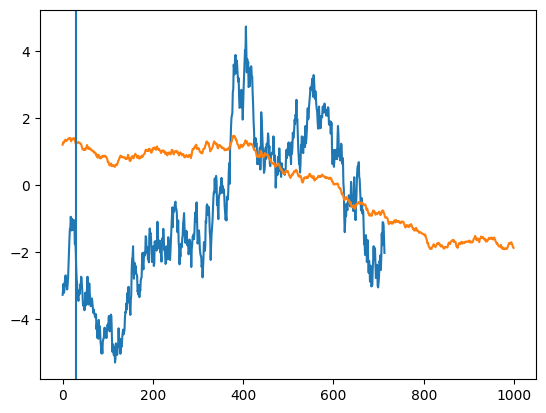

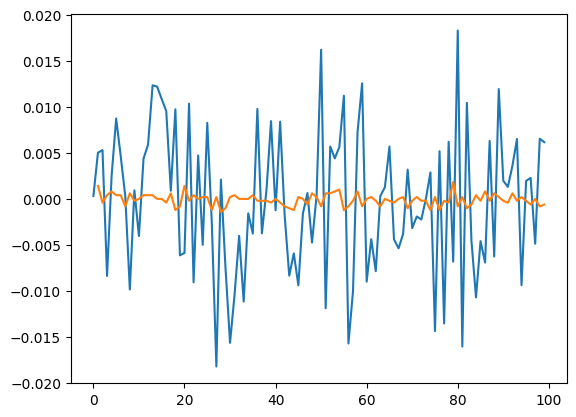

In [26]:
pair = ("10", "39")
shift = 286
plt.figure()
sns.lineplot((df[pair[0]] - df[pair[0]].mean()).values[shift:])
sns.lineplot((df[pair[1]] - df[pair[1]].mean()).values)
plt.axvline(x = 30)

plt.figure()
sns.lineplot((df[pair[0]].pct_change()).values[shift:shift+100])
sns.lineplot((df[pair[1]].pct_change()).values[:100])